In [39]:
import mne
import matplotlib.pyplot as plt
import sys
import os
import pathlib
SCRIPT_DIR = pathlib.Path.cwd()
sys.path.append(os.path.dirname(SCRIPT_DIR))

from continuous_control_bci.util import channel_names
mne.set_log_level('warning')



In [35]:
raw = mne.io.read_raw_gdf("../data/pilot_1/calibration/horse_reighns_pilot_driving.gdf",
                             preload=True)

In [36]:
channel_names
original_channel_names = [f"Channel {i + 1}" for i in range(32)] + [f"EX {i + 1}" for i in range(8)]
renaming = {original: new for original, new in zip(original_channel_names, channel_names)}

In [37]:
raw = raw.set_eeg_reference()
raw = raw.set_channel_types(dict.fromkeys(["EX 1", "EX 2", "EX 3", "EX 4"], "emg"))
raw = raw.set_channel_types(dict.fromkeys(["EX 5", "EX 6", "EX 7", "EX 8"], "eog"))
raw = raw.rename_channels(renaming)
raw = raw.set_montage("standard_1020", on_missing='raise')

In [38]:
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,35 points
Good channels,"32 EEG, 4 EMG, 4 EOG"
Bad channels,None
EOG channels,"LHEOG, RHEOG, UVEOG, LVEOG"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


In [40]:
import numpy as np

raw = raw.notch_filter(np.arange(50, 501, 50), picks='emg', method='fir', phase='minimum') # Multiple notches only implemented for FIR
raw = raw.notch_filter(50, method='fir', phase='minimum')
raw = raw.filter(30, 500, picks='emg', method='iir', phase='forward')
raw = raw.filter(2, 30, picks='eeg', method='iir', phase='forward')
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,35 points
Good channels,"32 EEG, 4 EMG, 4 EOG"
Bad channels,None
EOG channels,"LHEOG, RHEOG, UVEOG, LVEOG"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,2.00 Hz
Lowpass,30.00 Hz


In [33]:
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,35 points
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,2.00 Hz
Lowpass,30.00 Hz


In [41]:
LEFT_HAND_EVENT = "769"
RIGHT_HAND_EVENT = "770"
END_OF_TRIAL_EVENT = "800"  # Used for rests

events, _ = mne.events_from_annotations(raw, event_id={LEFT_HAND_EVENT: 1,
                                                           RIGHT_HAND_EVENT: 2,
                                                           END_OF_TRIAL_EVENT: 3
                                                      })

In [43]:
tmin = 2.25
tmax = 2.25 + 3.75
# Now we'd expect the movement 1 + 1.25 = 2.25 seconds in the timing may be learned
# It should stay until 6 seconds in. The first and last second should both be "empty"

event_ids = dict(left=1, right=2, rest=3
                )
    
epochs = mne.Epochs(
    raw,
    events,
    event_ids,
    tmin ,
    tmax + 0.5,
    baseline=None,
    preload=True,
)
epochs.ch_names

['Fp1',
 'AF3',
 'F7',
 'F3',
 'FC1',
 'FC5',
 'T7',
 'C3',
 'CP1',
 'CP5',
 'P7',
 'P3',
 'Pz',
 'PO3',
 'O1',
 'Oz',
 'O2',
 'PO4',
 'P4',
 'P8',
 'CP6',
 'CP2',
 'C4',
 'T8',
 'FC6',
 'FC2',
 'F4',
 'F8',
 'AF4',
 'Fp2',
 'Fz',
 'Cz',
 'Left-extension',
 'Left-flexion',
 'Right-flexion',
 'Right-extension',
 'LHEOG',
 'RHEOG',
 'UVEOG',
 'LVEOG']

/Users/ivopascal/.local/share/virtualenvs/continuous_control_bci-_i6LbcKu/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


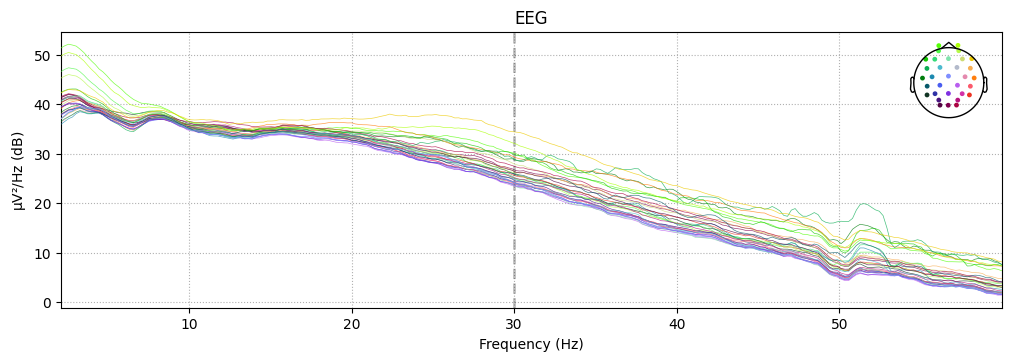

In [44]:
epochs.compute_psd(fmin=2, fmax=60).plot()
plt.show()

In [47]:
X = epochs.get_data(copy=True, picks=['eeg', 'emg', 'eog'])
y = epochs.events[:, -1] - 1

from sklearn.model_selection import train_test_split
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # Before we do anything, lock some up!
X_train, X_val, y_train, y_val = train_test_split(X_train_whole, y_train_whole, test_size=1/9, random_state=42) # Then we'll use this to make sure we're not overfitting

In [57]:
X.shape

(80, 40, 8705)

In [48]:
X_train_emg = np.abs(X_train[:, 32:36, :]).mean(axis=2)
X_val_emg = np.abs(X_val[:, 32:36, :]).mean(axis=2)

1.0


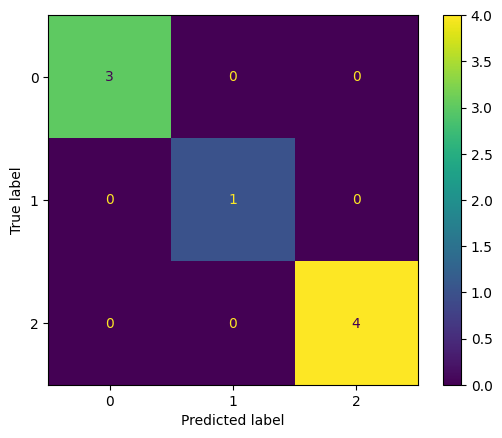

In [49]:
# This shows that in terms of EMG we're doing fine!

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import ConfusionMatrixDisplay
lda = LDA()
lda.fit(X_train_emg, y_train)
print(lda.score(X_val_emg, y_val))
ConfusionMatrixDisplay.from_estimator(lda, X_val_emg, y_val)
plt.show()

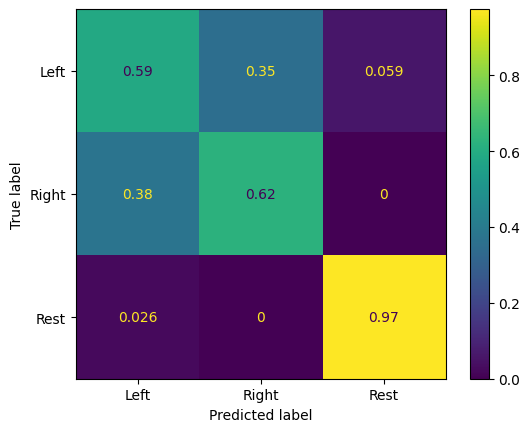

              precision    recall  f1-score   support

        Left       0.59      0.59      0.59        17
       Right       0.62      0.62      0.62        16
        Rest       0.97      0.97      0.97        39

    accuracy                           0.81        72
   macro avg       0.73      0.73      0.73        72
weighted avg       0.81      0.81      0.81        72



In [54]:
# So this has roughly 0.75% accuracy. That seems to be mostly because it's good at classifying rest compared to the classes. 
# We can get 70% accuracy with EEG and only 2 classes. It't not incredible, but it's certainly much better than random guessing!
# But we get down to 60% accuracy when adding rest!
# 61-67 for CSP=3 with Log.Regres.
# 61-67 for CSP=4 with Log.Regres.
# 61-61 for CSP=3 with LDA
# 61-61 for CSP=4 with LDA
# 55-60 for CSP=6 with LDA
# 54 - 44 for CSP=8 with LDA

from sklearn.pipeline import Pipeline
from mne.decoding import CSP
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict


X__train_whole_eeg = X_train_whole[:, :32, :]
X_train_eeg = X_train[:, :32, :]
X_val_eeg = X_val[:, :32, :]


clf_eeg = Pipeline([("CSP", CSP(n_components=4, reg=None, log=True, norm_trace=False)),
            ("classifier", LogisticRegression())])
clf_eeg.fit(X_train_eeg, y_train)

X_train_whole_eeg = X_train_whole[:, :32, :]

y_train_whole_pred = cross_val_predict(clf_eeg, X_train_whole_eeg, y_train_whole, cv=10)

ConfusionMatrixDisplay.from_predictions(y_train_whole, y_train_whole_pred,  display_labels=["Left", "Right", "Rest"], normalize='true')
plt.show()

print(classification_report(y_train_whole, y_train_whole_pred, target_names=["Left", "Right", "Rest"]))

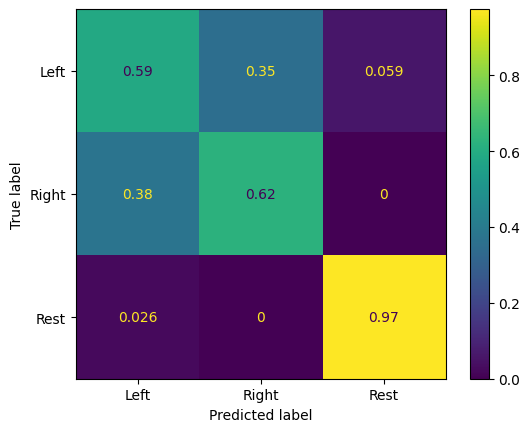

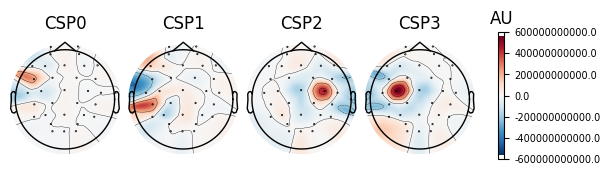

In [56]:

clf_eeg.steps[0][1].plot_filters(info=raw.pick('eeg').info)
plt.show()

In [ ]:
clf_eeg.steps[0][1].plot_filters(info=raw.pick('eeg').info)
